### Data load

In [304]:
import pandas as pd

test_data = pd.read_csv('./open/test_data.csv')
train_data = pd.read_csv('./open/train_data.csv')
topic_dict = pd.read_csv('./open/topic_dict.csv')
submission = pd.read_csv('./open/sample_submission.csv')

print(train_data.columns)
print(test_data.columns)
print(submission.columns)

Index(['index', 'title', 'topic_idx'], dtype='object')
Index(['index', 'title'], dtype='object')
Index(['index', 'topic_idx'], dtype='object')


### 글자만 남기기

In [309]:
import re

# train_data['title'] = train_data['title'].map(lambda x:re.sub('[^가-힣]', ' ', x).strip())
# test_data['title'] = test_data['title'].map(lambda x:re.sub('[^가-힣]', ' ', x).strip())
# train_data['title'] = train_data['title'].map(lambda x:re.sub('\W', ' ', x).strip())
# test_data['title'] = test_data['title'].map(lambda x:re.sub('\W', ' ', x).strip())
train_data['title'] = train_data['title'].map(lambda x:re.sub('[\W\d]', ' ', x).strip())
test_data['title'] = test_data['title'].map(lambda x:re.sub('[\W\d]', ' ', x).strip())


train_data.head()

,index,title,topic_idx
0,0,인천 핀란드 항공기 결항 휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다 구글 조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명 공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


### 3~7글자 단어, 가장 많ㅇ느 단어를 가진 뉴스의 단어수

In [358]:
import myfunc

all_news_title = train_data['title'].tolist() + test_data['title'].tolist()
words = myfunc.get_word_list(all_news_title, 3, 7)
num_word_list = myfunc.get_len_most_long_seq(all_news_title)

### 데이터 정제 (단어 분할)

In [164]:
from tqdm import tqdm
import re

for word in tqdm(words):
    train_data['title'] = train_data['title'].map(lambda x:x.replace(word, ' {} '.format(word)))
    test_data['title'] = test_data['title'].map(lambda x:x.replace(word, ' {} '.format(word)))

train_data['title'] = train_data['title'].map(lambda x:re.sub('\s+', ' ', x).strip())
test_data['title'] = test_data['title'].map(lambda x:re.sub('\s+', ' ', x).strip())

100%|██████████████████████████████████████████████████████████████████████████| 68971/68971 [1:25:12<00:00, 13.49it/s]


### 정제된 데이터 저장

In [165]:
# train_data.to_csv('./refined_train_data.csv', index=False)
# test_data.to_csv('./refined_test_data.csv', index=False)

### 정제된 데이터 불러오기

In [36]:
import pandas as pd

# train_data = pd.read_csv('./refined_train_data.csv')
# test_data = pd.read_csv('./refined_test_data.csv')
train_data = pd.read_csv('./refined_train_data_3word_1_no_num.csv')
test_data = pd.read_csv('./refined_test_data_3word_1_no_num.csv')

topic_dict = pd.read_csv('./open/topic_dict.csv')
submission = pd.read_csv('./open/sample_submission.csv')

num_topic = len(topic_dict)

In [37]:
import myfunc

all_news_title = train_data['title'].tolist() + test_data['title'].tolist()
num_words = len(myfunc.get_word_list(all_news_title))
max_len_words = myfunc.get_len_most_long_seq(all_news_title)
print('가장 많은 단어를 가진 뉴스의 단어수 :', max_len_words)

가장 많은 단어를 가진 뉴스의 단어수 : 14


### 데이터 전처리

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import myfunc

words = myfunc.get_word_list(all_news_title)

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(all_news_title)

word_index = tokenizer.word_index
# tokenizer.word_index = emb_model.wv.key_to_index

training_sequences = tokenizer.texts_to_sequences(train_data['title'])
training_padded = pad_sequences(training_sequences, maxlen=max_len_words, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(test_data['title'])
testing_padded1 = pad_sequences(testing_sequences, maxlen=max_len_words, padding='post', truncating='post')

print(num_words, len(tokenizer.word_index))

67799 67758


### topic 갯수에 따른 데이터 가중치 구하기

In [39]:
import numpy as np

num_news_per_topic = train_data.groupby('topic_idx').count()['title']
max_topic = max(num_news_per_topic)
weights = max_topic / np.array(num_news_per_topic)
weights

array([1.58146766, 1.22613308, 1.03626732, 1.28585876, 1.        ,
       1.10038944, 1.13005481])

### 모델 정의

In [40]:
import tensorflow as tf

def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, 16, input_length=max_len_words),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(topic_dict['topic_idx']), activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(lr = 0.001)
    # optimizer = tf.keras.optimizers.SGD(lr = 0.001, momentum=0.9)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

### KFold

In [41]:
from sklearn.model_selection import KFold
import myfunc
import tensorflow as tf
import numpy as np

BATCH_SIZE = 128
# callback1 = myfunc.HybridScheduler()
callback2 = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
models1 = []
historys1 = []

for tra_ind, val_ind in KFold(shuffle=True).split(range(len(training_padded))):
    tra_padded = training_padded[tra_ind]
    tra_idx = train_data['topic_idx'][tra_ind]
    val_padded = training_padded[val_ind]
    val_idx = train_data['topic_idx'][val_ind]
    
    train_ds, valid_ds = myfunc.data_to_dataset(tra_padded, val_padded, 
                                                tra_idx, val_idx, 
                                                weights, num_topic,
                                                BATCH_SIZE=BATCH_SIZE)
    steps_per_epoch = np.ceil(num_topic * max_topic / BATCH_SIZE)

    model = get_model()
    num_epochs = 50
    history = model.fit(train_ds, 
                        validation_data=valid_ds, 
                        steps_per_epoch=int(steps_per_epoch*0.8),
                        validation_steps=int(steps_per_epoch*0.2),
                        epochs=num_epochs, 
                        callbacks=[callback2])
    
    models1.append(model)
    historys1.append(history)

Train for 334 steps, validate for 83 steps
Epoch 1/50
334/334 [==============================] - 4s 13ms/step - loss: 1.3032 - acc: 0.6007 - val_loss: 1.4605 - val_acc: 0.7669
Epoch 2/50
334/334 [==============================] - 4s 11ms/step - loss: 0.5929 - acc: 0.8439 - val_loss: 0.5632 - val_acc: 0.8443
Epoch 3/50
334/334 [==============================] - 4s 11ms/step - loss: 0.3706 - acc: 0.8995 - val_loss: 0.4913 - val_acc: 0.8406
Epoch 4/50
334/334 [==============================] - 4s 11ms/step - loss: 0.2566 - acc: 0.9309 - val_loss: 0.5070 - val_acc: 0.8400
Epoch 5/50
334/334 [==============================] - 3s 10ms/step - loss: 0.1907 - acc: 0.9487 - val_loss: 0.5439 - val_acc: 0.8361
Epoch 6/50
334/334 [==============================] - 3s 10ms/step - loss: 0.1480 - acc: 0.9591 - val_loss: 0.5949 - val_acc: 0.8267
Train for 334 steps, validate for 83 steps
Epoch 1/50
334/334 [==============================] - 5s 14ms/step - loss: 1.2680 - acc: 0.6114 - val_loss: 1.4513 -

### 또다른 정제된 데이터를 이용한 프로세스

In [42]:
import pandas as pd

# train_data = pd.read_csv('./refined_train_data.csv')
# test_data = pd.read_csv('./refined_test_data.csv')
train_data = pd.read_csv('./refined_train_data_2word_1_no_num.csv')
test_data = pd.read_csv('./refined_test_data_2word_1_no_num.csv')

topic_dict = pd.read_csv('./open/topic_dict.csv')
submission = pd.read_csv('./open/sample_submission.csv')

num_topic = len(topic_dict)

In [43]:
import myfunc

all_news_title = train_data['title'].tolist() + test_data['title'].tolist()
num_words = len(myfunc.get_word_list(all_news_title))
max_len_words = myfunc.get_len_most_long_seq(all_news_title)
print('가장 많은 단어를 가진 뉴스의 단어수 :', max_len_words)

가장 많은 단어를 가진 뉴스의 단어수 : 19


In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import myfunc

words = myfunc.get_word_list(all_news_title)

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(all_news_title)

word_index = tokenizer.word_index
# tokenizer.word_index = emb_model.wv.key_to_index

training_sequences = tokenizer.texts_to_sequences(train_data['title'])
training_padded = pad_sequences(training_sequences, maxlen=max_len_words, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(test_data['title'])
testing_padded2 = pad_sequences(testing_sequences, maxlen=max_len_words, padding='post', truncating='post')

print(num_words, len(tokenizer.word_index))

25802 25724


In [45]:
from sklearn.model_selection import KFold
import myfunc
import tensorflow as tf
import numpy as np

BATCH_SIZE = 128
# callback1 = myfunc.HybridScheduler()
callback2 = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')

models2 = []
historys2 = []

for tra_ind, val_ind in KFold(shuffle=True).split(range(len(training_padded))):
    tra_padded = training_padded[tra_ind]
    tra_idx = train_data['topic_idx'][tra_ind]
    val_padded = training_padded[val_ind]
    val_idx = train_data['topic_idx'][val_ind]
    
    train_ds, valid_ds = myfunc.data_to_dataset(tra_padded, val_padded, 
                                                tra_idx, val_idx, 
                                                weights, num_topic,
                                                BATCH_SIZE=BATCH_SIZE)
    steps_per_epoch = np.ceil(num_topic * max_topic / BATCH_SIZE)

    model = get_model()
    num_epochs = 50
    history = model.fit(train_ds, 
                        validation_data=valid_ds, 
                        steps_per_epoch=int(steps_per_epoch*0.8),
                        validation_steps=int(steps_per_epoch*0.2),
                        epochs=num_epochs, 
                        callbacks=[callback2])
    
    models2.append(model)
    historys2.append(history)

Train for 334 steps, validate for 83 steps
Epoch 1/50
334/334 [==============================] - 3s 10ms/step - loss: 1.1946 - acc: 0.6577 - val_loss: 1.3941 - val_acc: 0.7825
Epoch 2/50
334/334 [==============================] - 2s 7ms/step - loss: 0.5795 - acc: 0.8447 - val_loss: 0.5066 - val_acc: 0.8584
Epoch 3/50
334/334 [==============================] - 2s 7ms/step - loss: 0.4297 - acc: 0.8807 - val_loss: 0.4405 - val_acc: 0.8605
Epoch 4/50
334/334 [==============================] - 2s 7ms/step - loss: 0.3486 - acc: 0.9007 - val_loss: 0.4480 - val_acc: 0.8524
Epoch 5/50
334/334 [==============================] - 2s 7ms/step - loss: 0.2959 - acc: 0.9139 - val_loss: 0.4647 - val_acc: 0.8490
Epoch 6/50
334/334 [==============================] - 2s 7ms/step - loss: 0.2586 - acc: 0.9246 - val_loss: 0.4908 - val_acc: 0.8458
Train for 334 steps, validate for 83 steps
Epoch 1/50
334/334 [==============================] - 4s 11ms/step - loss: 1.1976 - acc: 0.6584 - val_loss: 1.4040 - val_

In [46]:
from tqdm import tqdm
import numpy as np

batch_sequence = []
pred_regression1 = []
pred_regression2 = []

################################

for sequence in tqdm(testing_padded1):
    batch_sequence.append(sequence)
    if BATCH_SIZE <= len(batch_sequence):
        batch_sequence = np.stack(batch_sequence)
        batch_pred = np.zeros((len(batch_sequence), num_topic))
        for m in models1:
            batch_pred += m.predict(batch_sequence)
        pred_regression1.append(batch_pred)
        batch_sequence = []
if 0 < len(batch_sequence):
    batch_sequence = np.stack(batch_sequence)
    batch_pred = np.zeros((len(batch_sequence), num_topic))
    for m in models1: 
        batch_pred += m.predict(batch_sequence)
    pred_regression1.append(batch_pred)
    batch_sequence = []
    
pred_regression1 = np.concatenate(pred_regression1)

################################

for sequence in tqdm(testing_padded2):
    batch_sequence.append(sequence)
    if BATCH_SIZE <= len(batch_sequence):
        batch_sequence = np.stack(batch_sequence)
        batch_pred = np.zeros((len(batch_sequence), num_topic))
        for m in models2:
            batch_pred += m.predict(batch_sequence)
        pred_regression2.append(batch_pred)
        batch_sequence = []
if 0 < len(batch_sequence):
    batch_sequence = np.stack(batch_sequence)
    batch_pred = np.zeros((len(batch_sequence), num_topic))
    for m in models2: 
        batch_pred += m.predict(batch_sequence)
    pred_regression2.append(batch_pred)
    batch_sequence = []
    
pred_regression2 = np.concatenate(pred_regression2)
    
    
pred_idx = np.argmax(pred_regression1 + pred_regression2, axis=-1)

100%|█████████████████████████████████████████████████████████████████████████████| 9131/9131 [00:11<00:00, 824.52it/s]


### 가중치 적용한 데이터셋

In [ ]:
import myfunc

BATCH_SIZE = 128
train_ds, valid_ds = myfunc.data_to_dataset(tra_padded, val_padded, 
                                            tra_idx, val_idx, 
                                            weights, BATCH_SIZE=BATCH_SIZE)
steps_per_epoch = np.ceil(len(topic_dict['topic_idx']) * max_topic / BATCH_SIZE)

In [383]:
import myfunc

callback1 = myfunc.HybridScheduler()
callback2 = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')

AttributeError: module 'myfunc' has no attribute 'HybridScheduler'

### 훈련

In [269]:
num_epochs = 50
history = model.fit(train_ds, 
                    validation_data=valid_ds, 
                    steps_per_epoch=int(steps_per_epoch*0.8),
                    validation_steps=int(steps_per_epoch*0.2),
                    epochs=num_epochs, 
                    callbacks=[callback2])
#                     callbacks=[callback2, callback2])

Train for 334 steps, validate for 83 steps
Epoch 1/100
334/334 [==============================] - 3s 9ms/step - loss: 1.2399 - acc: 0.6574 - val_loss: 1.4182 - val_acc: 0.8266
Epoch 2/100
334/334 [==============================] - 2s 7ms/step - loss: 0.6019 - acc: 0.8440 - val_loss: 0.5104 - val_acc: 0.8601
Epoch 3/100
334/334 [==============================] - 2s 7ms/step - loss: 0.4469 - acc: 0.8770 - val_loss: 0.4321 - val_acc: 0.8622
Epoch 4/100
334/334 [==============================] - 2s 7ms/step - loss: 0.3681 - acc: 0.8946 - val_loss: 0.4386 - val_acc: 0.8631
Epoch 5/100
334/334 [==============================] - 2s 7ms/step - loss: 0.3215 - acc: 0.9070 - val_loss: 0.4626 - val_acc: 0.8540
Epoch 6/100
334/334 [==============================] - 2s 7ms/step - loss: 0.2734 - acc: 0.9196 - val_loss: 0.4737 - val_acc: 0.8551


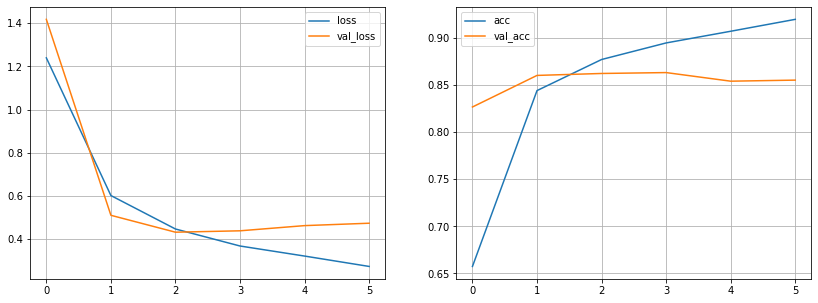

In [270]:
import matplotlib.pyplot as plt

def show_history(history, start=0):
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.plot(history.history['loss'][start:], label='loss')
    ax1.plot(history.history['val_loss'][start:], label='val_loss')
    ax1.grid()
    ax1.legend()
    ax2.plot(history.history['acc'][start:], label='acc')
    ax2.plot(history.history['val_acc'][start:], label='val_acc')
    ax2.grid()
    ax2.legend()

    plt.show()

show_history(history)

### predict

In [271]:
from tqdm import tqdm
import numpy as np

pred_idx = []
batch_sequence = []

for sequence in tqdm(testing_padded):
    batch_sequence.append(sequence)
    if 128 <= len(batch_sequence):
        batch_sequence = np.stack(batch_sequence)
        batch_pred = model.predict(batch_sequence)
        batch_pred = np.argmax(batch_pred, axis=-1)
        pred_idx.append(batch_pred)
        batch_sequence = []
        
if 0 < len(batch_sequence):
    batch_sequence = np.stack(batch_sequence)
    batch_pred = model.predict(batch_sequence)
    batch_pred = np.argmax(batch_pred, axis=-1)
    pred_idx.append(batch_pred)
    batch_sequence = []

pred_idx = np.concatenate(pred_idx)

100%|████████████████████████████████████████████████████████████████████████████| 9131/9131 [00:02<00:00, 3735.25it/s]


In [272]:
len(pred_idx)

9131

### submission csv만들기

In [59]:
submission['topic_idx'] = pred_idx
submission.to_csv('./submission/submission5.csv', index=False)

In [58]:
pred_idx = np.argmax(pred_regression1, axis=-1)

In [292]:
from sklearn.model_selection import KFold

for tra_ind, val_ind in KFold(shuffle=True).split(range(10)):
    print(tra_ind, val_ind)

[0 2 3 4 6 7 8 9] [1 5]
[0 1 3 4 5 7 8 9] [2 6]
[0 1 2 4 5 6 7 8] [3 9]
[1 2 3 4 5 6 7 9] [0 8]
[0 1 2 3 5 6 8 9] [4 7]


In [ ]:
tra_padded, val_padded, tra_idx, val_idx

In [ ]:
training_padded, train_data['topic_idx']

In [250]:
from xgboost import XGBClassifier

mm = XGBClassifier(n_estimators=200)#, learning_rate=1e-2)
mm.fit(tra_padded, tra_idx)

C:\____anaconda2020\envs\tfgpu\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [251]:
tt = mm.predict(tra_padded)
vv = mm.predict(val_padded)

In [234]:
from sklearn import metrics

In [252]:
print(metrics.accuracy_score(tra_idx,tt))
print(metrics.accuracy_score(val_idx,vv))

0.9436088395638629
0.668418747262374


In [10]:
aa = train_data['title'].tolist() + test_data['title'].tolist()
aa = list(map(lambda x:x.split(), aa))
aa[:10]

[['인천', '핀란드', '항공기', '결항', '휴가철', '여행객', '분통'],
 ['실리콘', '밸리', '넘어서', '겠다', '구글', '조원', '들여', '전역', '거점화'],
 ['이란', '외무', '긴장완화', '해결책', '은', '미국이', '경제전쟁', '멈추는', '것'],
 ['클린턴', '측근', '기업', '특수관계', '조명', '공과', '사', '맞물려종합'],
 ['시진핑', '트럼프', '에', '중미', '무역협상', '조속', '타결', '희망'],
 ['팔레', '스타인', '가자지구', '서', '세', '소년', '이스라엘', '군', '총격에', '사망'],
 ['인도', '년', '만에', '파키스탄', '공습', '테러', '캠프', '폭격종합', '보'],
 ['대선', '토론', '음담패설', '만회실패', '트럼프', '사과', '대신', '빌', '클린턴', '공격해', '역효과'],
 ['푸틴', '한반도', '상황', '진전', '위한', '방안', '김정은', '위원장', '과', '논의'],
 ['특검', '면죄부', '받은', '트럼프', '스캔들', '보도', '언론', '맹공', '국민의', '적']]

In [11]:
from gensim.models import Word2Vec

emb_model = Word2Vec(aa, vector_size=16, window=4, min_count=2)

C:\____anaconda2020\envs\tfgpu\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [73]:
# model_result1 = emb_model.wv.most_similar("항공기")
# print(model_result1)

[('절차', 0.9985571503639221), ('보고', 0.9982126951217651), ('조합원', 0.9979482293128967), ('전교조', 0.9977871775627136), ('계', 0.9974363446235657), ('건강', 0.997406542301178), ('결론', 0.9972735643386841), ('예방', 0.9972302317619324), ('처럼', 0.9971676468849182), ('불가피', 0.9971650242805481)]


In [12]:
emb_model.wv.index_to_key.insert(0, '<OOV>')

In [13]:
emb_model.wv.index_to_key[:10]

['<OOV>', '에', '대통령', '서', '일', '명', '도', '년', '첫', '월']

In [24]:
word_dic_key = list(emb_model.wv.key_to_index.keys())
word_dic_key.insert(0, '<OOV>')
word_dic_value = list(emb_model.wv.key_to_index.values())
word_dic_value.append(len(word_dic_value))

assert len(word_dic_key) == len(word_dic_value)

emb_model.wv.key_to_index = dict(zip(word_dic_key, word_dic_value))

In [25]:
print(list(emb_model.wv.key_to_index.keys())[:10])
print(list(emb_model.wv.key_to_index.values())[:10])

['<OOV>', '에', '대통령', '서', '일', '명', '도', '년', '첫', '월']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [27]:
import numpy as np

temp = np.zeros((1,16))
emb_model.wv.vectors = np.concatenate([temp, emb_model.wv.vectors])

print(emb_model.wv.vectors[:10])

In [28]:
len(emb_model.wv.vectors)

30253

In [22]:
list(emb_model.wv.key_to_index.values())[-10:]

[30242, 30243, 30244, 30245, 30246, 30247, 30248, 30249, 30250, 30251]

In [23]:
len(emb_model.wv.key_to_index)

30252

In [126]:
emb_model.wv.add_vector('<oov>', np.zeros(16))

20362

In [137]:
emb_model.wv.vectors = np.zeros(11)

In [138]:
emb_model.wv.vectors

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [141]:
dict(zip(['a','b','c'], [1,2,3]))

{'a': 1, 'b': 2, 'c': 3}

In [ ]:
# 단어분할 2~6 까지도 해보고
# word2vec의 vectors의 맨앞에 하나 추가 : <oov>, np.zeros(16)
# key_to_index와, index_to_key에도 

In [20]:
bb = {'a':1, 'b':2}
zz = list(bb.values())
zz.insert(0, 1)

In [17]:
bb.values()

dict_values([1, 2])

In [21]:
zz

[1, 1, 2]